### 📚 Libraries 🔖 ###

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import shap
import joblib

from pathlib import Path
import os, json, sys, time, calendar, random
from datetime import datetime
from collections import defaultdict

### 📜 Introduction 🪶 ###

In [2]:
# Paths
base_path = Path("..") / "data" / "processed"
prepr_path = Path("..") / "models"

train_df = pd.read_csv(base_path / "train_df.csv")
test_df = pd.read_csv(base_path / "test_df.csv")

# Load mappings
with open(base_path / "train_df_ward_province_mapping.json", "r", encoding="utf-8") as f:
    ward_province_map = json.load(f)
with open(base_path / "train_df_year_train_mapping.json", "r", encoding="utf-8") as f:
    year_map_test = json.load(f)
with open(base_path / "train_df_year_test_mapping.json", "r", encoding="utf-8") as f:
    year_map_train = json.load(f)
with open(base_path / "train_df_day_month_mapping.json", "r", encoding="utf-8") as f:
    day_month_map = json.load(f)

In [3]:
train_df.describe()

,area_m2,bedrooms,bathrooms,floors,frontage,year,day_sin,day_cos,month_sin,month_cos,...,ward_province_clean_OtherWard | Phú Yên,ward_province_clean_OtherWard | Bến Tre,ward_province_clean_OtherWard | Quảng Trị,ward_province_clean_OtherWard | Quảng Nam,ward_province_clean_OtherWard | Vĩnh Long,ward_province_clean_OtherWard | Đồng Tháp,ward_province_clean_OtherWard | Hòa Bình,ward_province_clean_OtherWard | Điện Biên,ward_province_clean_OtherWard | Sóc Trăng,log_price
count,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,4.474700e+04,...,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000
mean,0.253506,0.073250,0.057059,0.107774,0.219858,0.277873,-0.918042,0.059013,-0.295439,1.257941e-03,...,0.000022,0.000134,0.000045,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,8.892280
std,1.190137,1.357388,0.897478,0.885316,0.414155,0.833646,0.230514,0.317148,0.767032,5.695578e-01,...,0.004727,0.011579,0.006685,0.004727,0.004727,0.004727,0.004727,0.004727,0.004727,1.088086
min,-1.514196,-1.562377,-1.150657,-2.176736,0.000000,-2.000000,-0.998717,-1.000000,-1.000000,-1.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147
25%,-0.456662,-0.520792,-0.618207,-0.500000,0.000000,0.000000,-0.994522,-0.250653,-1.000000,-5.000000e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.476580
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.951057,0.104528,-0.500000,-1.836970e-16,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.881975
75%,0.543338,0.479208,0.381793,0.500000,0.000000,1.000000,-0.937752,0.347305,0.500000,5.000000e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.433564
max,8.940964,9.895056,6.381793,4.281206,1.000000,1.000000,0.994522,1.000000,1.000000,1.000000e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.764218


In [4]:
test_df.describe()

,area_m2,bedrooms,bathrooms,floors,frontage,year,day_sin,day_cos,month_sin,month_cos,...,ward_province_clean_OtherWard | Phú Yên,ward_province_clean_OtherWard | Bến Tre,ward_province_clean_OtherWard | Quảng Trị,ward_province_clean_OtherWard | Quảng Nam,ward_province_clean_OtherWard | Vĩnh Long,ward_province_clean_OtherWard | Đồng Tháp,ward_province_clean_OtherWard | Hòa Bình,ward_province_clean_OtherWard | Điện Biên,ward_province_clean_OtherWard | Sóc Trăng,log_price
count,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,1.118700e+04,...,11187.0,11187.000000,11187.0,11187.0,11187.000000,11187.0,11187.000000,11187.0,11187.0,11187.000000
mean,0.251126,0.071774,0.054190,0.097530,0.224546,0.274873,-0.915387,0.056247,-0.303853,6.470250e-03,...,0.0,0.000089,0.0,0.0,0.000179,0.0,0.000089,0.0,0.0,8.896764
std,1.207791,1.348127,0.883543,0.892033,0.417302,0.829878,0.235233,0.321842,0.767308,5.647571e-01,...,0.0,0.009455,0.0,0.0,0.013370,0.0,0.009455,0.0,0.0,1.075586
min,-1.514196,-1.562377,-1.081360,-2.215826,0.000000,-2.000000,-0.998717,-1.000000,-1.000000,-1.000000e+00,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.693147
25%,-0.456662,-0.520792,-0.618207,-0.500000,0.000000,0.000000,-0.994522,-0.250653,-1.000000,-5.000000e-01,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,8.476580
50%,0.000000,0.000000,0.015700,0.000000,0.000000,0.000000,-0.951057,0.104528,-0.866025,-1.836970e-16,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,8.880586
75%,0.528767,0.453829,0.381793,0.500000,0.000000,1.000000,-0.937752,0.347305,0.500000,5.000000e-01,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,9.433564
max,8.916930,9.895056,6.381793,4.289900,1.000000,1.000000,0.994522,1.000000,1.000000,1.000000e+00,...,0.0,1.000000,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,13.651816


### 🗃️ Data Pipeline 📦 ###

In [14]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root)

if src_path not in sys.path:
    sys.path.append(src_path)

#Import necessary preprocessing features
from workarounds.preprocessing.feature_preprocessing.encoders.label_encoder import LabelEncoding
from workarounds.preprocessing.feature_preprocessing.encoders.target_encoder import TargetEncoding
from workarounds.preprocessing.feature_preprocessing.encoders.one_hot_encoder import OneHotEncoding
from workarounds.preprocessing.feature_preprocessing.scalers.minmax_scaler import MinMaxScaling
from workarounds.preprocessing.feature_preprocessing.scalers.standard_scaler import StandardScaling
from workarounds.preprocessing.feature_preprocessing.normalization.normalizer import Normalizing
from workarounds.preprocessing.feature_preprocessing.outliers.iqr_removal import IQRMethod
from workarounds.preprocessing.feature_preprocessing.outliers.zscore_removal import ZScoreMethod
from workarounds.preprocessing.feature_preprocessing.transformers.boxcox import BoxCoxTransformer
from workarounds.preprocessing.feature_preprocessing.transformers.yeo_johnson import YeoJohnsonTransformer
from workarounds.preprocessing.feature_preprocessing.pipeline import PreprocessingPipeline
from workarounds.preprocessing.feature_preprocessing.imputers.mice import MICEImputation
from workarounds.preprocessing.feature_preprocessing.scalers.robust_scaler import RobustScaling

### 🔄 Pre-loaded Models (Available Use Only) ⏳ ###

In [15]:
prepipeline = joblib.load(f"{prepr_path}/preprocessing_20251230_163143.pkl")
print("Preprocessing Pipeline Is Ready")

Preprocessing Pipeline Is Ready


In [21]:
final_model = joblib.load(f"{prepr_path}/final_stacking_model_20251230_225852.pkl")
print("Modeling Pipeline Is Ready")

Modeling Pipeline Is Ready


### ✂️ Modeling Workflow 🪚 ###

In [69]:
# Features & Target
X_train = train_df.drop(columns=["log_price"])
y_train = train_df["log_price"]

X_test = test_df.drop(columns=["log_price"])
y_test = test_df["log_price"]

In [9]:
# Baseline models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        "model": model.__class__.__name__,
        "RMSE_log": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE_log": mean_absolute_error(y_test, y_pred),
        "R2_log": r2_score(y_test, y_pred)
    }

# Linear Regression Families
lr = LinearRegression()
ridge = Ridge(alpha = 10)
lasso = Lasso(alpha = 0.05)
elastic = ElasticNetCV(
    l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9],
    alphas = np.logspace(-3, 1, 20),
    cv = 5,
    n_jobs = -1
)

baseline_results = []
for model in [lr, ridge, lasso, elastic]:
    baseline_results.append(evaluate_model(model, X_train, y_train, X_test, y_test))

baseline_df = pd.DataFrame(baseline_results)
print("Baseline Linear Models: \n", baseline_df)

Baseline Linear Models: 
               model  RMSE_log   MAE_log    R2_log
0  LinearRegression  0.854019  0.458566  0.369502
1             Ridge  0.853426  0.458155  0.370378
2             Lasso  0.937078  0.539395  0.240900
3      ElasticNetCV  0.855390  0.459777  0.367477


In [10]:
# Tree-based Models
dt = DecisionTreeRegressor(
    max_depth = 10, 
    min_samples_leaf = 10, 
    max_features = 0.7, 
    random_state = 42
)

rf = RandomForestRegressor(
    n_estimators = 500, 
    max_depth = 22, 
    min_samples_leaf = 5, 
    min_samples_split = 10, 
    max_features = 0.7, 
    bootstrap = True, 
    random_state = 42, 
    n_jobs = -1
)

tree_models = [dt, rf]
tree_results = [evaluate_model(m, X_train, y_train, X_test, y_test) for m in tree_models]

tree_df = pd.DataFrame(tree_results)
print("Tree-based Models: \n", tree_df)

Tree-based Models: 
                    model  RMSE_log   MAE_log    R2_log
0  DecisionTreeRegressor  0.867028  0.468945  0.350148
1  RandomForestRegressor  0.799648  0.401353  0.447228


In [11]:
# Gradient Boosting Machines
xgb_model = xgb.XGBRegressor(
    n_estimators = 2000, 
    learning_rate = 0.02, 
    max_depth = 5,
    min_child_weight = 15,
    subsample = 0.8, 
    colsample_bytree = 0.8,
    reg_alpha = 0.2, # L1
    reg_lambda = 2.0, # L2
    objective = "reg:squarederror",
    random_state = 42, 
    n_jobs = -1
)

lgb_model = lgb.LGBMRegressor(
    n_estimators = 3000, 
    learning_rate = 0.02,
    num_leaves = 96,
    min_child_samples = 20,
    reg_alpha = 0.2, # L1
    reg_lambda = 2.0, # L2
    subsample = 0.85, 
    colsample_bytree = 0.85,
    max_bin = 255,
    random_state = 42,
    n_jobs = -1
)

gb_results = [evaluate_model(model, X_train, y_train, X_test, y_test) for model in [xgb_model, lgb_model]]

# Catboost
cat_features = [X_train.columns.get_loc(col) for col in X_train.columns if col.startswith("ward_province_clean_")]
cat_model = CatBoostRegressor(
    iterations = 1500, 
    learning_rate = 0.03, 
    depth = 6, 
    l2_leaf_reg = 10, 
    loss_function = "RMSE", 
    verbose = 200, 
    random_state = 42
)
cat_model.fit(X_train, y_train, cat_features = cat_features)

cat_results = evaluate_model(cat_model, X_train, y_train, X_test, y_test)

# Merge dataframe
gb_df = pd.DataFrame(gb_results)
cat_df = pd.DataFrame([cat_results])

final_result_df = pd.concat([gb_df, cat_df], ignore_index = True)

print("Boosting Comparison:\n")
final_result_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1258
[LightGBM] [Info] Number of data points in the train set: 44747, number of used features: 117
[LightGBM] [Info] Start training from score 8.892280
0:	learn: 1.0797550	total: 165ms	remaining: 4m 6s
200:	learn: 0.8579675	total: 2.85s	remaining: 18.4s
400:	learn: 0.8399450	total: 5.14s	remaining: 14.1s
600:	learn: 0.8289287	total: 6.99s	remaining: 10.5s
800:	learn: 0.8210998	total: 8.73s	remaining: 7.62s
1000:	learn: 0.8143839	total: 11.5s	remaining: 5.71s
1200:	learn: 0.8088029	total: 14.9s	remaining: 3.72s
1400:	learn: 0.8040793	total: 18.4s	remaining: 1.3s
1499:	learn: 0.8015861	total: 19.9s	remaining: 0us
0:	learn: 1.0794984	total: 9.65ms	remaining: 1

,model,RMSE_log,MAE_log,R2_log
0,XGBRegressor,0.794318,0.392695,0.454573
1,LGBMRegressor,0.786468,0.399969,0.465300
2,CatBoostRegressor,0.806835,0.402026,0.437248


In [13]:
# Model Stacking
stack_model = StackingRegressor(
    estimators = [
        ("ridge", Ridge(alpha = 5.0)),
        ("rf", rf), # bagging, reduces variances
        ("lgb", lgb_model), # faster with large datasets and well handling categorical columns
    ], 
    final_estimator = Ridge(alpha = 1.0), 
    passthrough = True, # Avoid feature explosion
    cv = 5,
    n_jobs = -1
)

In [14]:
# Model Stacking 2
stack_model_2 = StackingRegressor(
    estimators = [
        ("rf", rf), # bagging, reduces variances
        ("lgb", lgb_model), # faster with large datasets and well handling categorical columns
        ("xgb", xgb_model)
    ], 
    final_estimator = Ridge(alpha = 5.0), 
    passthrough = False, # Avoid feature explosion
    cv = 5,
    n_jobs = -1
)

In [15]:
# List of stacking models
stack_models = [stack_model, stack_model_2]
stack_names = ["Stacking 1", "Stacking 2"]

for name, model in zip(stack_names, stack_models):
    # Evaluate on train/test split
    results = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"\n{name} Evaluation (Train/Test Split):")
    print(results)
    
    # Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=kf, n_jobs=-1)
    cv_rmse_log = -cv_scores.mean()
    cv_rmse_std = cv_scores.std()
    print(f"CV RMSE (log): {cv_rmse_log:.4f} ± {cv_rmse_std:.4f}")
    
    # Sanity Check: Overfitting
    train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")


Stacking 1 Evaluation (Train/Test Split):
{'model': 'StackingRegressor', 'RMSE_log': np.float64(0.7838419960166346), 'MAE_log': 0.3885915530838216, 'R2_log': 0.46886465797266197}
CV RMSE (log): 0.8248 ± 0.0208
Train RMSE: 0.6830, Test RMSE: 0.7838

Stacking 2 Evaluation (Train/Test Split):
{'model': 'StackingRegressor', 'RMSE_log': np.float64(0.7827160471278054), 'MAE_log': 0.3849425818415087, 'R2_log': 0.47038945947750177}
CV RMSE (log): 0.8225 ± 0.0224
Train RMSE: 0.7127, Test RMSE: 0.7827


In [16]:
# Final Model Selection, choose the model with the best RMSE/MAE tradeoff and interpretability
final_model = stack_model_2.fit(X_train, y_train)
print("Final Model Ready For Prediction")

Final Model Ready For Prediction


### 💾 Ready-to-use Model 📤 ###

In [17]:
# Path to save the model
export_path = Path("..") / "models"
export_path.mkdir(parents = True, exist_ok = True)

# Rename the file to export - Explicit timeline
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = export_path / f"final_stacking_model_{timestamp}.pkl"

# Save the model
joblib.dump(final_model, model_path)

print(f"Model successfully saved to {model_path}")

Model successfully saved to ..\models\final_stacking_model_20251230_225852.pkl


### 🧪 Arbitrary Testing / Predicting Input 🗂️ ###

In [17]:
# Ward province pairs checking
def invert_ward_province_map(ward_province_map):
    """
    Returns:
    {
    "Hà Nội": ["Ba Đình", "Hà Đông", ...],
    "Hồ Chí Minh" : ["Thủ Đức", "Quận 2", ...]
    }
    """
    city_to_wards = defaultdict(list)

    for _, clean in ward_province_map.items():
        ward, province = [x.strip() for x in clean.split("|")]
        city_to_wards[province].append(ward)

    return dict(city_to_wards)

# Cyclical encoding for day and month
def encode_cyclical_day_month(day, month, year):
    days_in_month = calendar.monthrange(year, month)[1]
    return (
        np.sin(2 * np.pi * day / days_in_month),
        np.cos(2 * np.pi * day / days_in_month),
        np.sin(2 * np.pi * month / 12),
        np.cos(2 * np.pi * month / 12)
    )

def predict_house_price(input_dict, prepipeline, final_model, ward_map):
    """
    Predict house price given input features and a pre-fitted preprocessing pipeline.

    Parameters
    ----------
    input_dict : dict
        Dictionary containing features of the house.
    prepipeline : PreprocessingPipeline
        Pre-fitted preprocessing pipeline (saved via joblib).
    final_model : sklearn-like regressor
        Trained model predicting log(price).
    ward_map : dict or set
        Map of known wards used in training.

    Returns
    -------
    price_pred : float
        Predicted house price (original scale, not log).
    """
    # Convert input dict to DataFrame
    df = pd.DataFrame([input_dict])

    # Combine ward + province
    df["ward_province"] = df["ward"] + " | " + df["province"]
    df["ward_province_clean"] = df["ward_province"].apply(
        lambda x: x if x in ward_map else "OtherWard | " + input_dict.get("province", "")
    )

    # Cyclical encoding
    df['day_sin'], df['day_cos'], df['month_sin'], df['month_cos'] = \
        encode_cyclical_day_month(
            input_dict.get("day", 1),
            input_dict.get("month", 1),
            input_dict.get("year", 2025)
        )

    # Drop redundant columns (not needed for model)
    drop_cols = ['ward', 'ward_province', 'day', 'month']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    # Add missing indicators for numerical columns
    num_cols = ["area_m2", "bedrooms", "bathrooms", "floors"]
    for col in num_cols:
        df[f"{col}_missing"] = int(pd.isna(input_dict.get(col, None)))

    # Transform features using the pre-fitted pipeline
    X_encoded = prepipeline.transform(df)

    # Predict log-price
    log_price_pred = final_model.predict(X_encoded)

    # Convert log-price back to original scale
    price_pred = np.expm1(log_price_pred)[0]

    return price_pred

In [18]:
CITY_WARD_MAP = invert_ward_province_map(ward_province_map)
HOUSE_RANGES = {
    "area_m2": {
        "base": (35, 120),
        "extreme": (15, 390)
    },
    "bedrooms": {
        "base": (1, 5),
        "extreme": (0, 10)
    },
    "bathrooms": {
        "base": (1, 5),
        "extreme": (0, 10)
    },
    "floors": {
        "base": (1, 4),
        "extreme": (1, 10)
    }
}

# Get house input
def get_house_input(mode = "manual", **kwargs):
    """
    mode:
    - manual → returns kwargs as-is
    - random → base random
    - extreme → extreme random
    - mixed → mixed random
    """
    if mode == "manual":
        return kwargs

    if mode in {"random", "base"}:
        return random_house_input(scenario="base")

    if mode == "extreme":
        return random_house_input(scenario="extreme")

    if mode == "mixed":
        return random_house_input(scenario="mixed")

    raise ValueError("Unknown mode")

# Random house input
def random_house_input(city = None, scenario = "base", year_range = (2024, 2027), seed = None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # City & Ward
    if city is None:
        city = random.choice(list(CITY_WARD_MAP.keys()))

    ward = random.choice(CITY_WARD_MAP[city])

    # Scenario control
    def draw(col):
        if scenario == "base":
            lo, hi = HOUSE_RANGES[col]["base"]
        elif scenario == "extreme":
            lo, hi = HOUSE_RANGES[col]["extreme"]
        else: # mixed
            lo, hi = random.choice([
                HOUSE_RANGES[col]["base"],
                HOUSE_RANGES[col]["extreme"]
            ])
        return random.randint(lo, hi)

    year = random.randint(*year_range)
    month = random.randint(1, 12)
    day = random.randint(1, calendar.monthrange(year, month)[1])

    return {
        "area_m2" : draw("area_m2"),
        "bedrooms" : draw("bedrooms"),
        "bathrooms": draw("bathrooms"),
        "floors": draw("floors"),
        "frontage": random.choice([True, False]),
        "ward": ward,
        "province": city,
        "year": year,
        "month": month,
        "day": day
    }

In [24]:
new_house_input = get_house_input(mode = "base")
new_house_input

{'area_m2': 87,
 'bedrooms': 4,
 'bathrooms': 1,
 'floors': 3,
 'frontage': False,
 'ward': 'OtherWard',
 'province': 'Kiên Giang',
 'year': 2027,
 'month': 3,
 'day': 7}

In [25]:
predicted_price = predict_house_price(
    new_house_input,
    prepipeline=prepipeline,
    final_model=final_model,
    ward_map=ward_province_map
)

print(f"Predicted House Price: {predicted_price:.2f} million VND")

Predicted House Price: 2895.16 million VND


### 📈 House Property Forecasting 🔮 ###

#### A. Predicted Prices Across Wards ####

In [76]:
HOUSE_PROFILES = {
    "Small": {
        "area_m2": 50,       
        "bedrooms": 2,
        "bathrooms": 1,
        "floors": 2,
        "frontage": False    
    },
    "Medium": {
        "area_m2": 75,        
        "bedrooms": 3,
        "bathrooms": 2,
        "floors": 3,
        "frontage": True     
    },
    "Large": {
        "area_m2": 100,       
        "bedrooms": 4,
        "bathrooms": 3,
        "floors": 4,
        "frontage": True     
    }
}

def build_house_input(house_profile, city, ward, year, month, day = 15, overrides = None):
    inp = {
        **HOUSE_PROFILES[house_profile],
        "province" : city,
        "ward" : ward,
        "year" : year,
        "month" : month,
        "day" : day
    }

    if overrides:
        inp.update(overrides)
    return inp

In [54]:
# Generate predictions
def generate_ward_comparison(house_profiles, wards_by_city, year, month, prepipeline, model, ward_map, city_ward_map):
    records = []

    for profile in house_profiles:
        for city, wards in wards_by_city.items():
            if city not in city_ward_map:
                continue

        for ward in wards:
            if ward not in city_ward_map[city]:
                continue

            inp = build_house_input(profile, city, ward, year, month)

            price = predict_house_price(inp, prepipeline, model, ward_map)

            records.append({
                "City" : city,
                "Ward" : ward,
                "HouseType" : profile,
                "PredictedPrice_millionVND" : price
            })
            
    return pd.DataFrame(records)

In [56]:
# Define Wards
major_wards_by_city = {
    "Hồ Chí Minh" : ["Quận 1", "Quận 3", "Quận 7", "Thủ Đức"],
    "Hà Nội" : ["Ba Đình", "Hoàn Kiếm", "Cầu Giấy", "Nam Từ Liêm"],
    "Đà Nẵng": ["Hải Châu", "Thanh Khê", "Sơn Trà"],
    "Bình Dương": ["Thủ Dầu Một", "Dĩ An", "Thuận An"]
}

ward_df = generate_ward_comparison(
    house_profiles=HOUSE_PROFILES.keys(),
    wards_by_city=major_wards_by_city,
    year=2026,
    month=6,
    prepipeline=prepipeline,
    model=final_model,
    ward_map=ward_province_map,
    city_ward_map=CITY_WARD_MAP
)

ward_df

,City,Ward,HouseType,PredictedPrice_millionVND
0,Bình Dương,Thủ Dầu Một,Small,1728.738652
1,Bình Dương,Dĩ An,Small,1728.738652
2,Bình Dương,Thuận An,Small,1728.738652
3,Bình Dương,Thủ Dầu Một,Medium,3865.837381
4,Bình Dương,Dĩ An,Medium,3865.837381
5,Bình Dương,Thuận An,Medium,3865.837381
6,Bình Dương,Thủ Dầu Một,Large,5589.292311
7,Bình Dương,Dĩ An,Large,5589.292311
8,Bình Dương,Thuận An,Large,5589.292311


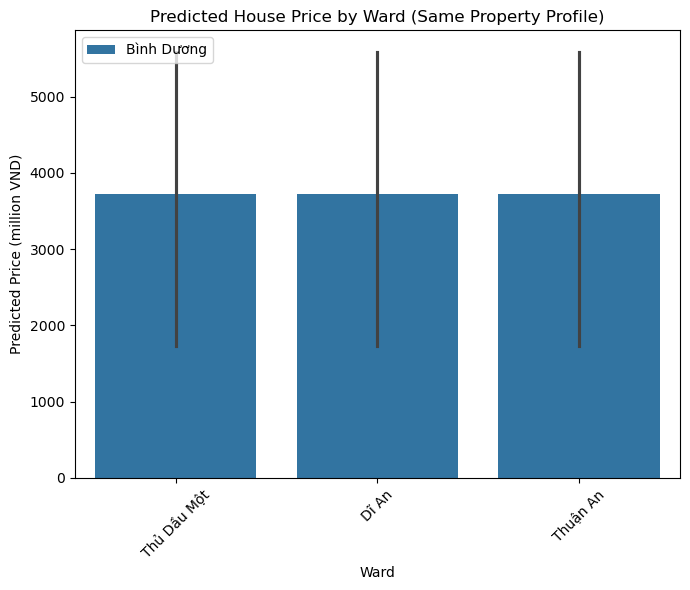

In [57]:
# Visualisations
plt.figure(figsize = (7, 6))
sns.barplot(data = ward_df, x = "Ward", y = "PredictedPrice_millionVND", hue = "City")
plt.xticks(rotation = 45)
plt.ylabel("Predicted Price (million VND)")
plt.title("Predicted House Price by Ward (Same Property Profile)")
plt.tight_layout()
plt.legend(loc = "upper left")
plt.show()

#### B. Monthly Price Trend in 2026 ####

In [58]:
def generate_monthly_trend_multi(city, ward, year, house_profiles, prepipeline, model, ward_map, city_ward_map):
    records = []

    for profile in house_profiles:
        for month in range(1, 13):
            inp = build_house_input(profile, city, ward, year, month)
            price = predict_house_price(inp, prepipeline, model, ward_map)

            records.append({
                "City" : city,
                "Ward" : ward,
                "Month" : month,
                "HouseType" : profile,
                "PredictedPrice_millionVND" : price
            })
            
    return pd.DataFrame(records)

In [61]:
# Generate trends for HCM & Hanoi
trend_hcm = generate_monthly_trend_multi(
    city="Hồ Chí Minh",
    ward="Quận 1",
    year=2026,
    house_profiles=HOUSE_PROFILES.keys(),
    prepipeline=prepipeline,
    model=final_model,
    ward_map=ward_province_map,
    city_ward_map=CITY_WARD_MAP
)

trend_hn = generate_monthly_trend_multi(
    city="Hà Nội",
    ward="Cầu Giấy",
    year=2026,
    house_profiles=HOUSE_PROFILES.keys(),
    prepipeline=prepipeline,
    model=final_model,
    ward_map=ward_province_map,
    city_ward_map=CITY_WARD_MAP
)

trend_df = pd.concat([trend_hcm, trend_hn])

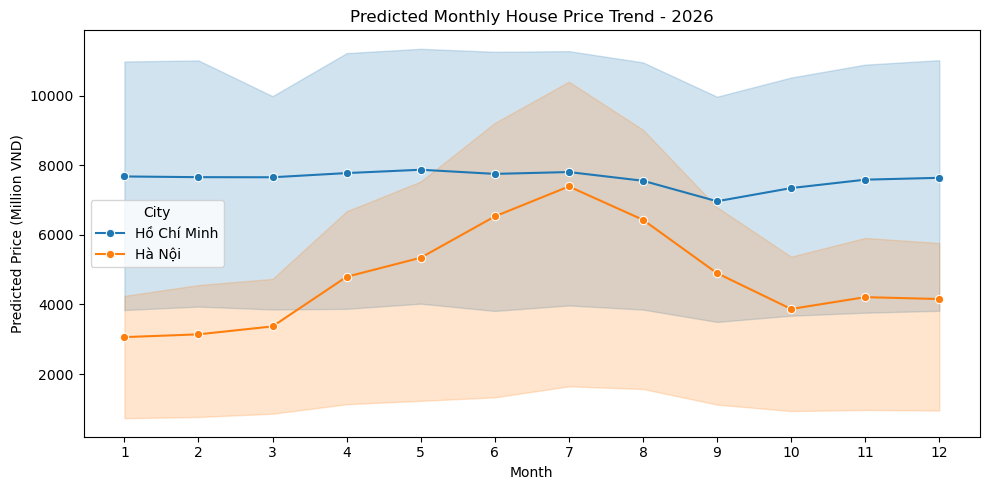

In [62]:
plt.figure(figsize = (10, 5))
sns.lineplot(data = trend_df, x = "Month", y = "PredictedPrice_millionVND", hue = "City", marker = "o")
plt.xticks(range(1, 13))
plt.ylabel("Predicted Price (Million VND)")
plt.title("Predicted Monthly House Price Trend - 2026")
plt.tight_layout()
plt.show()

#### C. Sensitivity Analysis ####

In [63]:
SENSITIVITY_RANGES = {
    "area_m2": np.arange(30, 201, 30),
    "bedrooms": np.arange(1, 7),
    "bathrooms": np.arange(1, 6),
    "floors": np.arange(1, 8)
}

FEATURE_LABELS = {
    "area_m2": "Area (m²)",
    "bedrooms": "Bedrooms",
    "bathrooms": "Bathrooms",
    "floors": "Floors"
}

def generate_sensitivity_by_profile(house_profile, city, ward, feature, values, year, month, prepipeline, model, ward_map, city_ward_map):
    # Validation
    if city not in city_ward_map:
        raise ValueError(f"City not in training data: {city}")

    if ward not in city_ward_map[city]:
        raise ValueError(f"Ward not trained: {ward} | {city}")

    records = []

    for v in values:
        inp = build_house_input(
            house_profile=house_profile,
            city=city,
            ward=ward,
            year=year,
            month=month,
            overrides={feature: v}
        )

        price = predict_house_price(
            inp,
            prepipeline,
            model,
            ward_map
        )

        records.append({
            feature: v,
            "HouseType": house_profile,
            "PredictedPrice_millionVND": price
        })

    return pd.DataFrame(records)


def generate_all_feature_sensitivity(house_profiles, city, ward, year, month, prepipeline, model, ward_map, city_ward_map):
    dfs = []

    for feature, values in SENSITIVITY_RANGES.items():
        for profile in house_profiles:
            df = generate_sensitivity_by_profile(
                house_profile = profile,
                city = city,
                ward = ward,
                feature = feature,
                values = values,
                year = year,
                month = month,
                prepipeline = prepipeline,
                model = model,
                ward_map = ward_map,
                city_ward_map = city_ward_map
            )
            df["Feature"] = feature
            dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

In [64]:
sensitivity_df = generate_all_feature_sensitivity(
    house_profiles=HOUSE_PROFILES.keys(),
    city="Hồ Chí Minh",
    ward="Thủ Đức",
    year=2026,
    month=6,
    prepipeline=prepipeline,
    model=final_model,
    ward_map=ward_province_map,
    city_ward_map=CITY_WARD_MAP
)

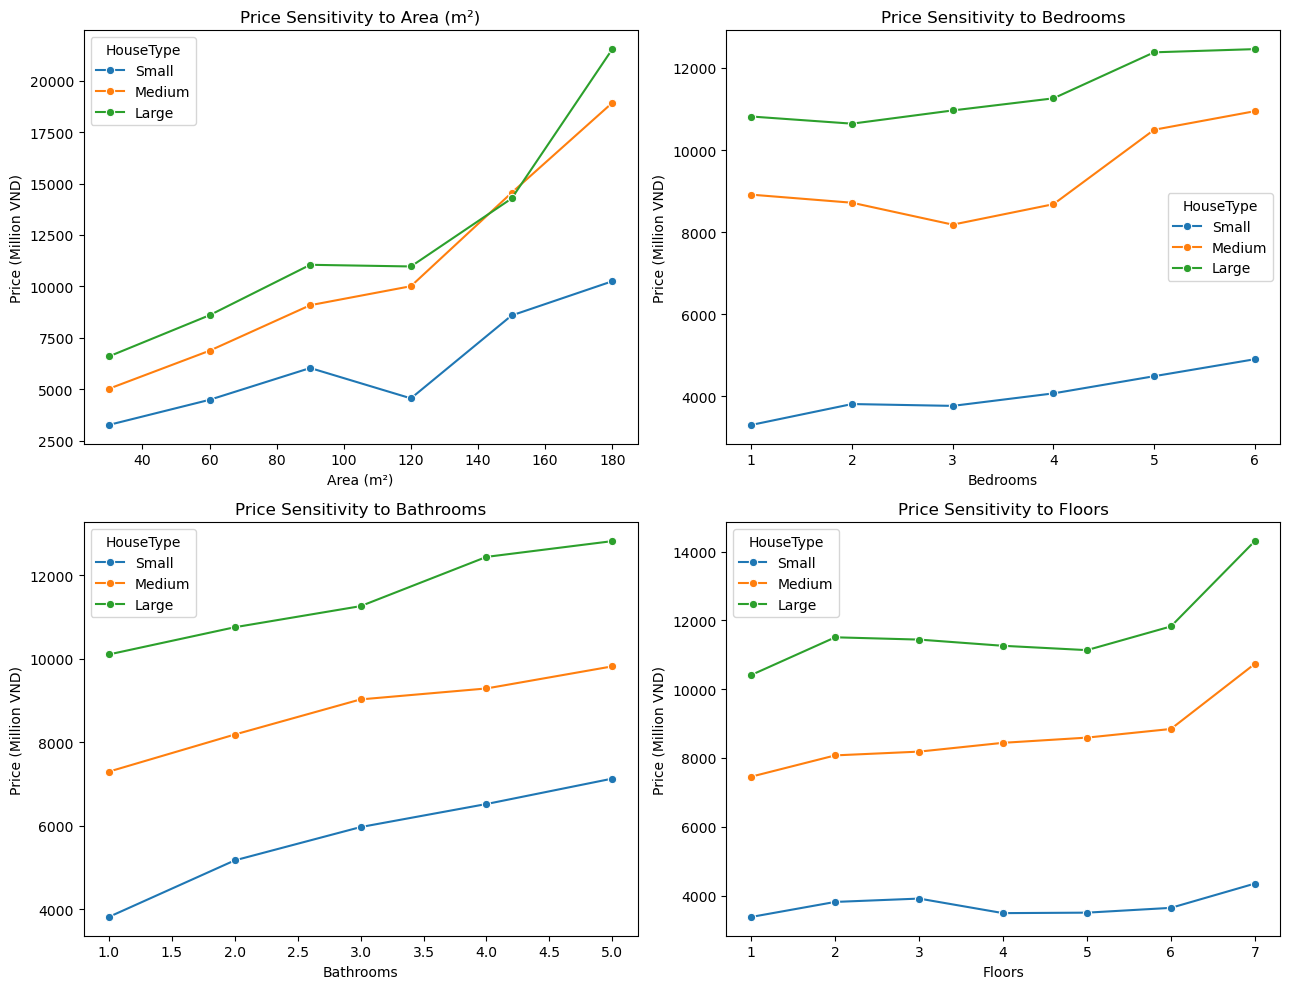

In [65]:
fig, axes = plt.subplots(2, 2, figsize = (13, 10))
axes = axes.flatten()

for ax, (feature, label) in zip(axes, FEATURE_LABELS.items()):
    subset = sensitivity_df[sensitivity_df["Feature"] == feature]

    sns.lineplot(data = subset, x = feature, y = "PredictedPrice_millionVND", hue = "HouseType", marker = "o", ax = ax)

    ax.set_title(f"Price Sensitivity to {label}")
    ax.set_ylabel("Price (Million VND)")
    ax.set_xlabel(label)

plt.tight_layout()
plt.show()

#### D. Scenario Comparison Bars ####

In [66]:
def generate_scenarios(base_input):
    def clamp(val, lo=0):
        return max(val, lo)

    return {
        "Base Case": base_input,

        "+1 Bedroom": {
            **base_input,
            "bedrooms": clamp(base_input["bedrooms"] + 1)
        },

        "+1 Bathroom": {
            **base_input,
            "bathrooms": clamp(base_input["bathrooms"] + 1)
        },

        "+1 Floor": {
            **base_input,
            "floors": clamp(base_input["floors"] + 1)
        },

        "No Frontage": {
            **base_input,
            "frontage": False
        },

        "With Frontage": {
            **base_input,
            "frontage": True
        },

        "Renovated (+10m²)": {
            **base_input,
            "area_m2": clamp(base_input["area_m2"] + 10, 10)
        },

        "Major Renovation (+30m²)": {
            **base_input,
            "area_m2": clamp(base_input["area_m2"] + 30, 10)
        }
    }

def evaluate_scenarios_delta(house_profile, city, ward, year, month, prepipeline, model, ward_map, city_ward_map):
    base = build_house_input(house_profile, city, ward, year, month)
    base_price = predict_house_price(base, prepipeline, model, ward_map)

    scenarios = generate_scenarios(base)
    records = []

    for name, inp in scenarios.items():
        price = predict_house_price(inp, prepipeline, model, ward_map)
        records.append({
            "Scenario" : name,
            "PriceDelta_millionVND" : price - base_price
        })

    return pd.DataFrame(records)

In [67]:
scenario_df = evaluate_scenarios_delta(
    house_profile="Medium",
    city="Hồ Chí Minh",
    ward="Quận 7",
    year=2026,
    month=6,
    prepipeline=prepipeline,
    model=final_model,
    ward_map=ward_province_map,
    city_ward_map=CITY_WARD_MAP
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_4936\1533275395.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=scenario_sorted, y="Scenario", x="PriceDelta_millionVND", palette = "coolwarm")


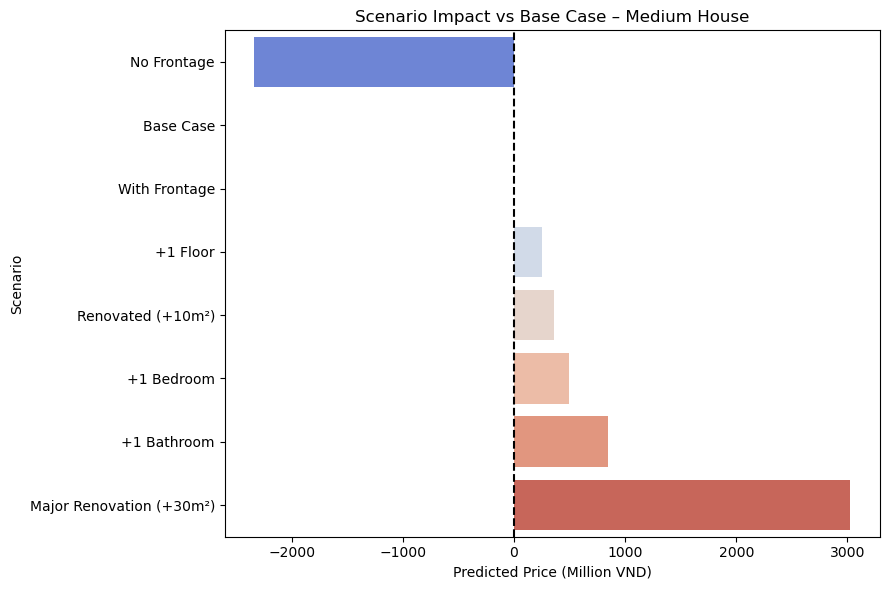

In [68]:
scenario_sorted = scenario_df.sort_values("PriceDelta_millionVND", ascending=True)

plt.figure(figsize=(9, 6))
sns.barplot(data=scenario_sorted, y="Scenario", x="PriceDelta_millionVND", palette = "coolwarm")

plt.axvline(0, color = "black", linestyle = "--")
plt.title("Scenario Impact vs Base Case – Medium House")
plt.xlabel("Predicted Price (Million VND)")
plt.tight_layout()
plt.show()

#### E. Residual vs Feature Diagnostics ####

In [82]:
# Prepare residuals
y_pred = final_model.predict(X_test)
residuals = y_test - y_pred

residual_df = X_test.copy()
residual_df["Residual_log"] = residuals

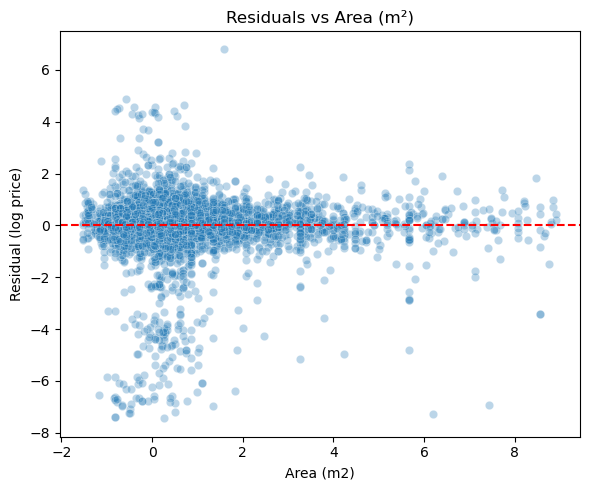

In [71]:
# Residual VS. Area
plt.figure(figsize=(6, 5))
sns.scatterplot(data=residual_df, x="area_m2", y="Residual_log", alpha=0.3)

plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Area (m²)")
plt.ylabel("Residual (log price)")
plt.xlabel("Area (m2)")

plt.tight_layout()
plt.show()

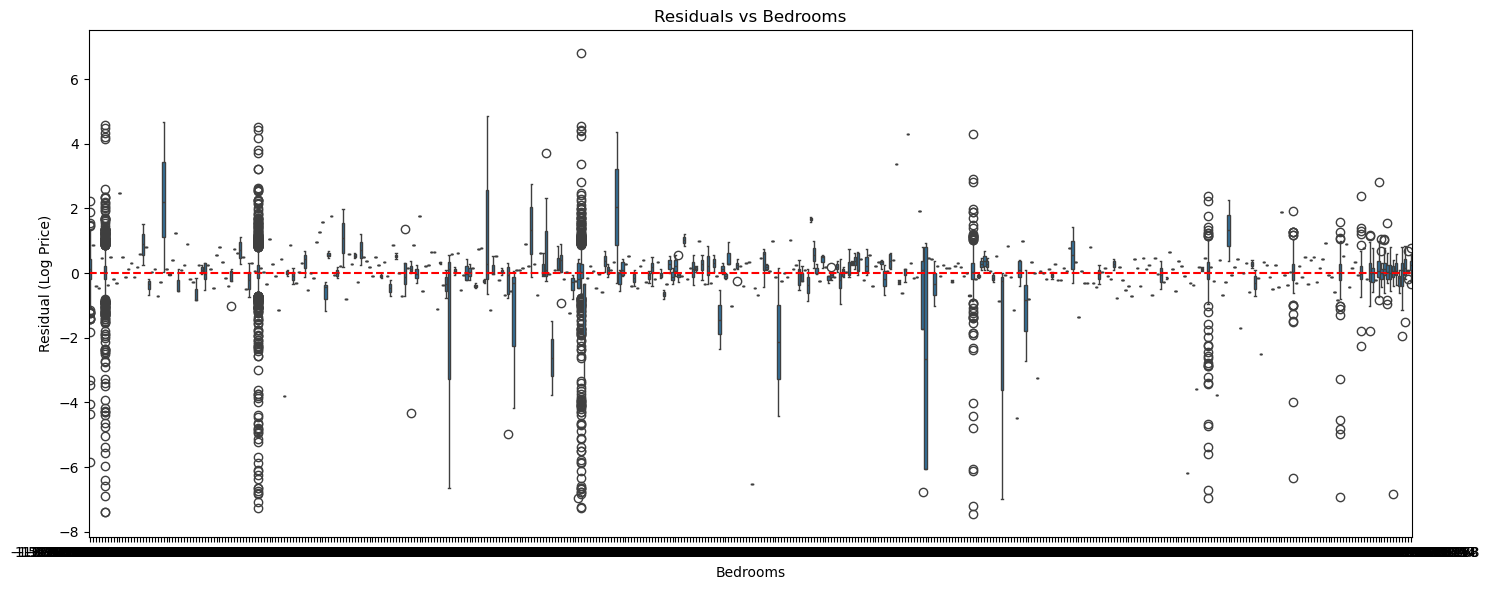

In [84]:
# Residual VS. Bedrooms
plt.figure(figsize=(15, 6))
sns.boxplot(data=residual_df, x="bedrooms", y="Residual_log")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Bedrooms")
plt.xlabel("Bedrooms")
plt.ylabel("Residual (Log Price)")

plt.tight_layout()
plt.show()

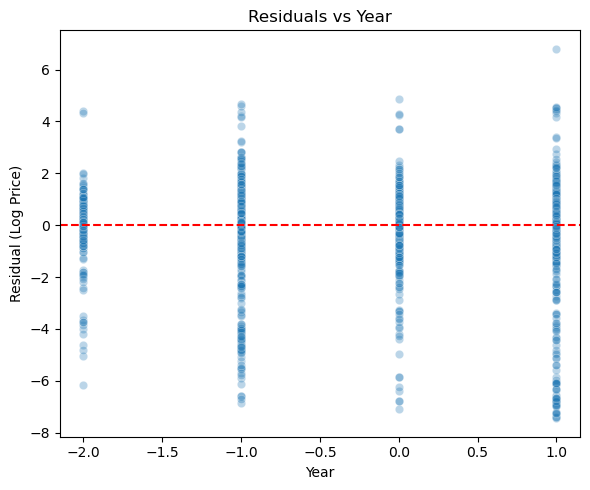

In [85]:
# Residual VS. Year (Time Drift)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=residual_df, x="year", y="Residual_log", alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Year")
plt.xlabel("Year")
plt.ylabel("Residual (Log Price)")

plt.tight_layout()
plt.show()

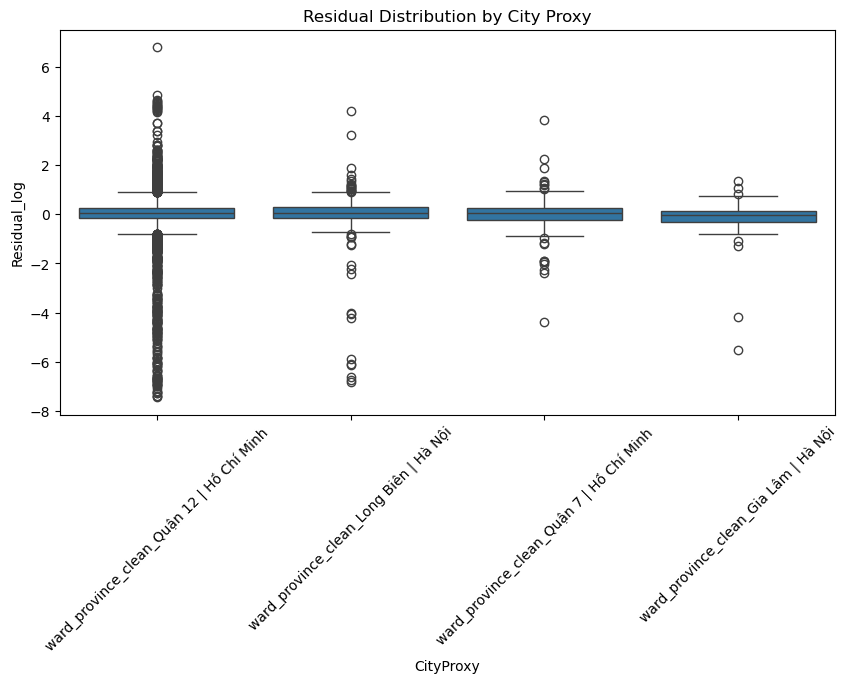

In [74]:
# Residual Distribution by City
city_cols = [c for c in residual_df.columns if c.startswith("ward_province_clean_")]

top_city = city_cols[:4]  # adjust if needed
residual_df["CityProxy"] = residual_df[top_city].idxmax(axis=1)

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=residual_df,
    x="CityProxy",
    y="Residual_log"
)
plt.xticks(rotation=45)
plt.title("Residual Distribution by City Proxy")
plt.show()

#### F. Confidence Band via Bootstrap ####

In [88]:
n_boot = 100
bootstrap_preds = []

for _ in range(n_boot):
    idx = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bs, y_bs = X_train.iloc[idx], y_train.iloc[idx]

    final_model.fit(X_bs, y_bs)
    pred = predict_house_price(
        new_house_input,
        prepipeline,
        final_model,
        ward_province_feature_map
    )
    bootstrap_preds.append(pred)

sns.histplot(bootstrap_preds, kde=True)
plt.axvline(np.mean(bootstrap_preds), color="red", linestyle="--")
plt.title("Prediction Uncertainty (Bootstrap Distribution)")
plt.show()

KeyboardInterrupt: 

### 📊 Analytic Efficiency 🧰 ###

#### Model Performance Comparison ####

In [75]:
# Combine results from previous modeling
stack_results = [
    {
        "model": "Stacking_1 (Ridge+RF+LGB)",
        "RMSE_log": 0.783842,
        "MAE_log": 0.388592,
        "R2_log": 0.468865
    },
    {
        "model": "Stacking_2 (RF+LGB+XGB)",
        "RMSE_log": 0.782716,
        "MAE_log": 0.384943,
        "R2_log": 0.470389
    }
]

all_results = pd.concat([
    baseline_df,
    tree_df,
    final_result_df,
    pd.DataFrame([stack_results])
], ignore_index = True)

# Visualisation melt
metrics_df = all_results.melt(
    id_vars = "model",
    value_vars = ["RMSE_log", "MAE_log", "R2_log"],
    var_name = "Metric",
    value_name = "Score"
)

plt.figure(figsize = (12, 6))
ax = sns.barplot(data = metrics_df, x = "model", y = "Score", hue = "Metric")

# Annotation
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.3f",   
        padding=3,
        fontsize=9
    )

plt.xticks(rotation = 15)
plt.title("Model Performance Comparison (Log Scale)")
plt.tight_layout()
plt.show()

NameError: name 'baseline_df' is not defined

In [59]:
all_results

,model,RMSE_log,MAE_log,R2_log
0,LinearRegression,1.054455,0.604112,0.375049
1,Ridge,1.049555,0.602704,0.380845
2,Lasso,1.165228,0.706207,0.236848
3,DecisionTreeRegressor,1.030126,0.554163,0.403556
4,RandomForestRegressor,0.949609,0.478195,0.493151
5,XGBRegressor,0.930400,0.469869,0.513449
6,LGBMRegressor,0.937287,0.478063,0.506219
7,CatBoostRegressor,0.942401,0.485893,0.500816
8,StackingRegressor,0.921709,0.461424,0.522496


#### Cross-Validation Stability ####

In [88]:
plt.figure(figsize = (6, 5))
sns.boxplot(y = -cv_scores)
plt.ylabel("RMSE (log)")
plt.title("Cross-Validation RMSE Distribution - Stacking Model")
plt.tight_layout()
plt.show()

print(f"Mean CV RSME (log): {-cv_scores.mean():.4f}")
print(f"Standard Deviation CV RSME (log): {-cv_scores.std():.4f}")

NameError: name 'cv_scores' is not defined

<Figure size 600x500 with 0 Axes>

#### Prediction Error Distribution ####

In [89]:
y_pred_stack = stack_model.predict(X_test)
residuals = y_test - y_pred_stack

plt.figure(figsize = (8, 5))
sns.histplot(residuals, bins = 50, kde = True)
plt.axvline(0, color = "red", linestyle = "--")
plt.title("Residual Distribution (Stacking Model)")
plt.xlabel("Residual (Log Price)")
plt.tight_layout()
plt.show()

NameError: name 'stack_model' is not defined

#### Predicted VS. Actual ####

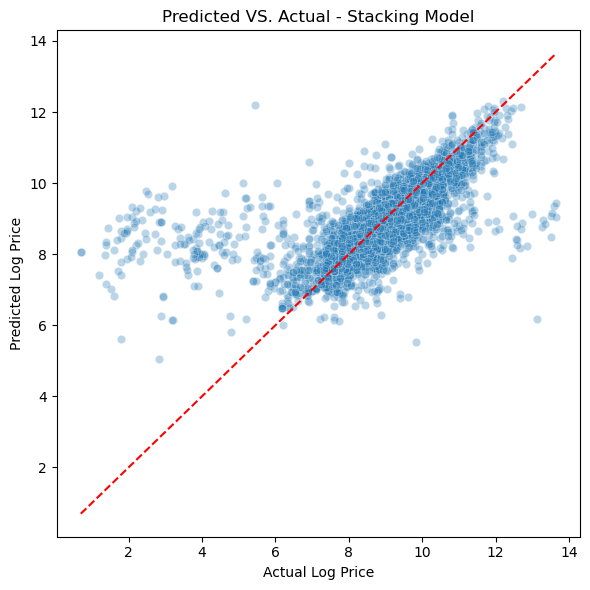

In [82]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test, y = y_pred_stack, alpha = 0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color = "red",
    linestyle = "--"
)

plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Predicted VS. Actual - Stacking Model")
plt.tight_layout()
plt.show()

#### Feature Importance Consistency ####

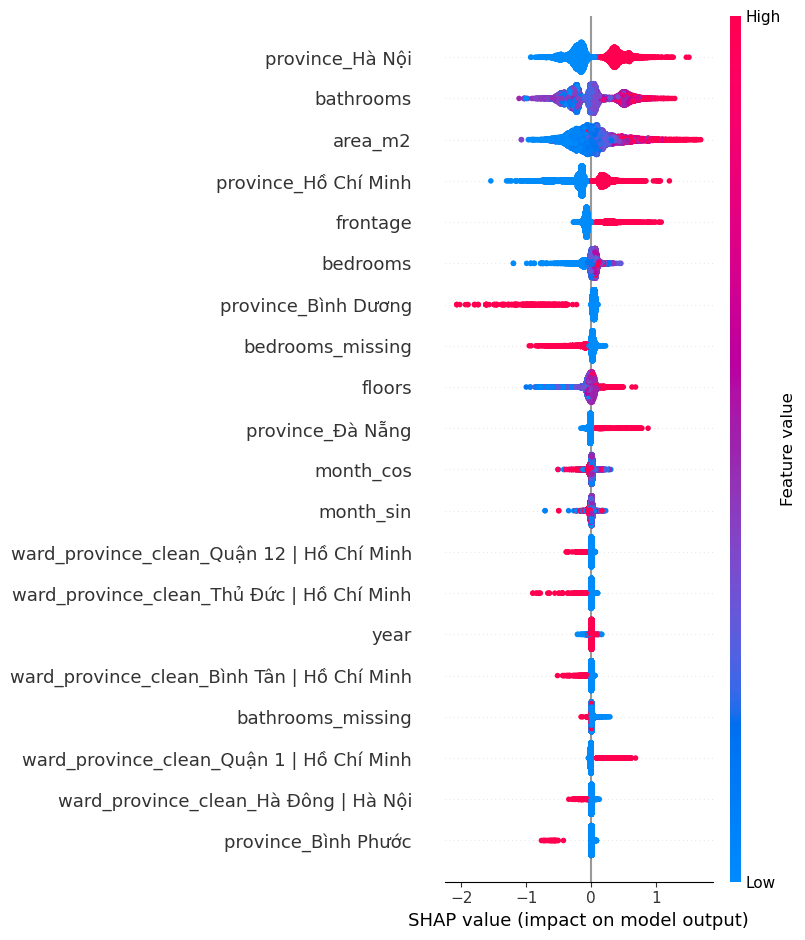

In [11]:
# Feature Importance (SHAP)
rf_model = stack_model.named_estimators_["rf"]

# Use the first estimator (RF) for TreeExplainer as example
explainer = shap.TreeExplainer()
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

#### Inference Time Comparison ####

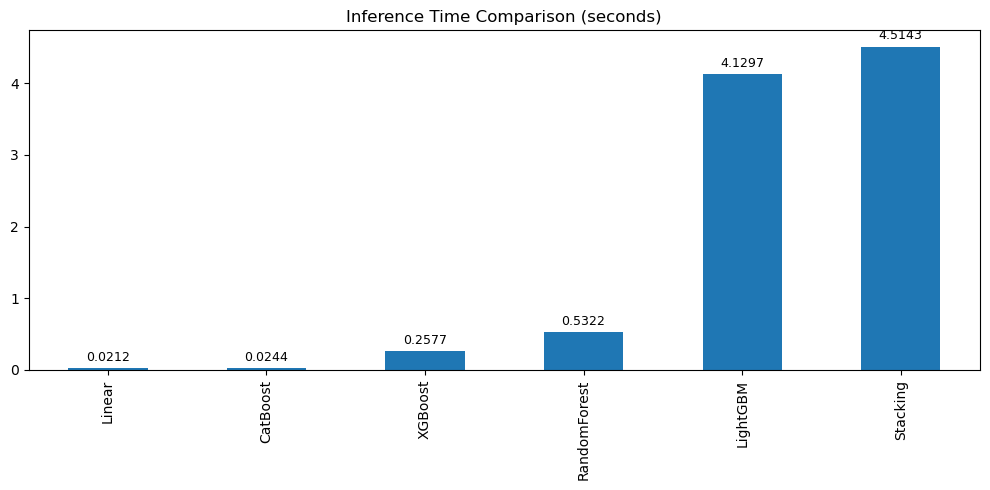

In [80]:
def benchmark_model(model, X, n_runs = 3):
    times = []
    for _ in range(n_runs):
        start = time.time()
        model.predict(X)
        times.append(time.time() - start)
    return np.mean(times)

timing_results = {
    "Linear" : benchmark_model(lr, X_test),
    "RandomForest": benchmark_model(rf, X_test),
    "XGBoost" : benchmark_model(xgb_model, X_test),
    "LightGBM" : benchmark_model(lgb_model, X_test),
    "CatBoost" : benchmark_model(cat_model, X_test),
    "Stacking" : benchmark_model(stack_model, X_test),
}

ax = (pd.Series(timing_results).sort_values().plot(kind="bar", figsize = (10, 5), title="Inference Time Comparison (seconds)"))

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()

### 🎯 Conclusion & Next Steps ⏩ ###